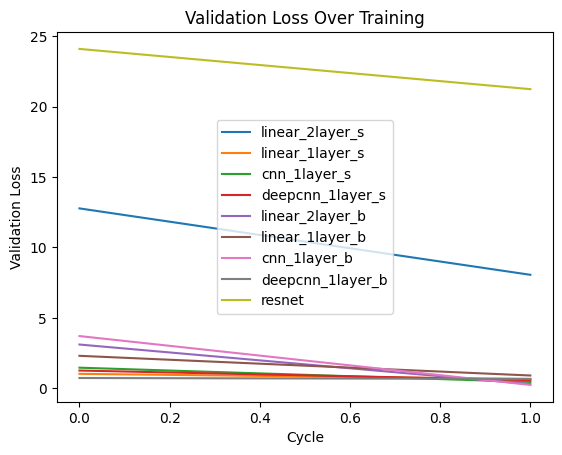

In [6]:
import torch
import matplotlib.pyplot as plt

# Load training results
results = torch.load("training_results.pth")

# Extract data
validation_losses = results["validation_losses"]
all_labels = results["all_labels"]
model_weights = results["model_weights"]

# Example: Plot validation loss curves
for model_name, losses in validation_losses.items():
    plt.plot(losses["val_5.0"], label=model_name)

plt.xlabel("Cycle")
plt.ylabel("Validation Loss")
plt.legend()
plt.title("Validation Loss Over Training")
plt.show()


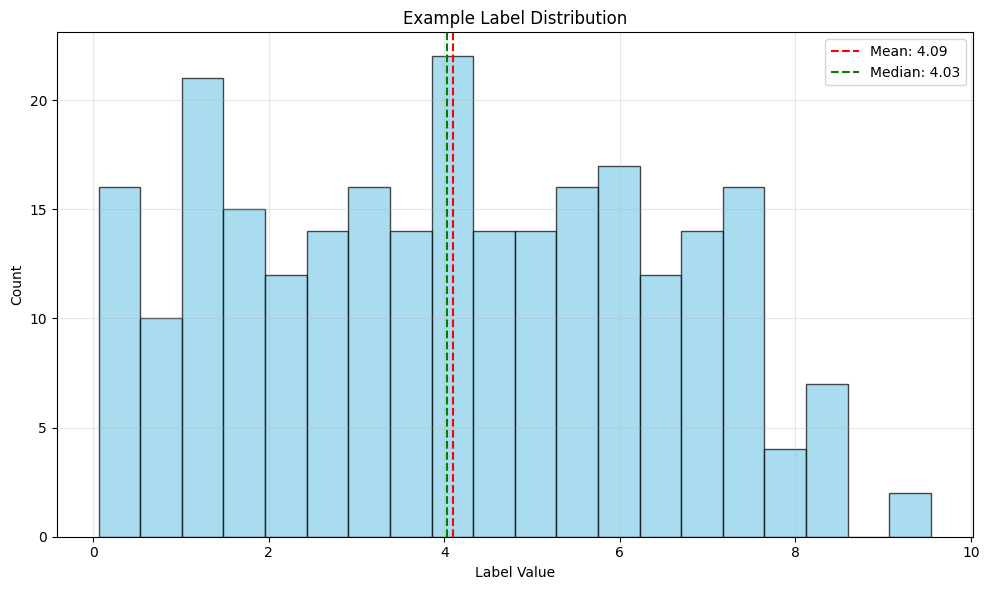

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_labels_histogram(labels_array, bins=10, title="Distribution of Labels", 
                          xlabel="Value", ylabel="Frequency", 
                          color='skyblue', edgecolor='black',
                          figsize=(10, 6), show_grid=True, 
                          show_mean=True, show_median=True):
    """
    Plot a histogram from a numpy array of labels.
    
    Parameters:
    -----------
    labels_array : numpy.ndarray
        The array of values to plot as histogram
    bins : int or sequence, default=10
        Number of bins or bin edges
    title : str, default="Distribution of Labels"
        Title of the plot
    xlabel : str, default="Value"
        Label for x-axis
    ylabel : str, default="Frequency"
        Label for y-axis
    color : str, default='skyblue'
        Color of the histogram bars
    edgecolor : str, default='black'
        Color of the histogram bar edges
    figsize : tuple, default=(10, 6)
        Figure size (width, height) in inches
    show_grid : bool, default=True
        Whether to show grid lines
    show_mean : bool, default=True
        Whether to show the mean line
    show_median : bool, default=True
        Whether to show the median line
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes objects
        For further customization if needed
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot histogram
    ax.hist(labels_array, bins=bins, color=color, edgecolor=edgecolor, alpha=0.7)
    
    # Add mean line if requested
    if show_mean and len(labels_array) > 0:
        mean_value = np.mean(labels_array)
        ax.axvline(mean_value, color='red', linestyle='dashed', linewidth=1.5, 
                  label=f'Mean: {mean_value:.2f}')
    
    # Add median line if requested
    if show_median and len(labels_array) > 0:
        median_value = np.median(labels_array)
        ax.axvline(median_value, color='green', linestyle='dashed', linewidth=1.5,
                  label=f'Median: {median_value:.2f}')
    
    # Add labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    
    # Add grid
    if show_grid:
        ax.grid(alpha=0.3)
    
    # Add legend if we have mean or median
    if (show_mean or show_median) and len(labels_array) > 0:
        ax.legend()
    
    plt.tight_layout()
    
    return fig, ax

# Example usage
if __name__ == "__main__":
    # Example data
    
    # Plot histogram
    fig, ax = plot_labels_histogram(
        all_labels, 
        bins=20,
        title="Example Label Distribution",
        xlabel="Label Value",
        ylabel="Count"
    )
    
    plt.show()